<a href="https://colab.research.google.com/github/jimenasalinas/RedditGoesGreen/blob/main/models/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ClimateBert

by Harsh Vardhan Pachisia



Links used:
1. https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270
2. https://towardsdatascience.com/part-1-data-cleaning-does-bert-need-clean-data-6a50c9c6e9fd
3. https://towardsdatascience.com/does-bert-need-clean-data-part-2-classification-d29adf9f745a
4. https://huggingface.co/climatebert/distilroberta-base-climate-sentiment
5. https://ai.plainenglish.io/bert-pytorch-implementation-prepare-dataset-part-1-efd259113e5a

In [10]:
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.nn.functional import softmax
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [11]:
# Mount GDrive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
data_path = "/content/drive/Shareddrives/adv-ml-project/Data/"
# took the filtered comments that Santi had done to make preprocessing easier
filtered_comments = pd.read_csv(data_path + "comments_filtered.csv")

In [13]:
filtered_comments.head()

,subreddit.name,date,body,sentiment,label
0,askreddit,2022-08-31 23:56:46,I think climate change tends to get some peopl...,0.6634,1
1,askreddit,2022-08-31 23:54:25,They need to change laws so it's more worth se...,0.4690,1
2,askreddit,2022-08-31 23:52:41,That a big part of the solution to climate cha...,0.8937,1
3,askreddit,2022-08-31 23:49:45,&gt;Not climate change mind you\n\nHi. I have ...,0.0000,1
4,worldnews,2022-08-31 23:48:15,"Climate change is not ""staring"" you in the fac...",-0.3453,0


In [14]:
filtered_comments.shape
# has close to a million records

(912334, 5)

In [15]:
# 1 is positive
# 0 is negative
filtered_comments.loc[:,'label'].value_counts()

1    469159
0    443175
Name: label, dtype: int64

In [16]:
filtered_comments.describe(include='all')
# so we have 26 subreddits, some duplicate text

,subreddit.name,date,body,sentiment,label
count,912334,912334,912334,892318.000000,912334.000000
unique,3,908230,890137,NaN,NaN
top,politics,2020-10-08 01:44:41,Climate change,NaN,NaN
freq,339167,5,6094,NaN,NaN
mean,NaN,NaN,NaN,-0.047641,0.514240
std,NaN,NaN,NaN,0.639993,0.499797
min,NaN,NaN,NaN,-0.999900,0.000000
25%,NaN,NaN,NaN,-0.652100,0.000000
50%,NaN,NaN,NaN,0.000000,1.000000
75%,NaN,NaN,NaN,0.542300,1.000000


In [17]:
# Ensure text is a string
filtered_comments['body'] = str(filtered_comments['body'])

Text pre-processing and sampling

In [19]:
sample_size = 10000 #100,000 body

# Take a random sample of the dataset
sampled_comments = filtered_comments.sample(n=sample_size, random_state=42)

# Selecting relevant columns
X = sampled_comments['body']  # Text data
y = sampled_comments['label']  # Sentiment labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
y_train.value_counts()

1    4102
0    3898
Name: label, dtype: int64

In [27]:
 y_test.value_counts()

1    1014
0     986
Name: label, dtype: int64

## Climate Bert model

https://huggingface.co/climatebert/distilroberta-base-climate-sentiment

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("climatebert/distilroberta-base-climate-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("climatebert/distilroberta-base-climate-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenization

In [21]:
def tokenize_data(data, tokenizer, batch_size=16, max_length=512):
    encoded_batches = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size].tolist()
        encoded_batch = tokenizer(batch, return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)
        encoded_batches.append(encoded_batch)
    return encoded_batches

encoded_train = tokenize_data(X_train, tokenizer)
encoded_test = tokenize_data(X_test, tokenizer)

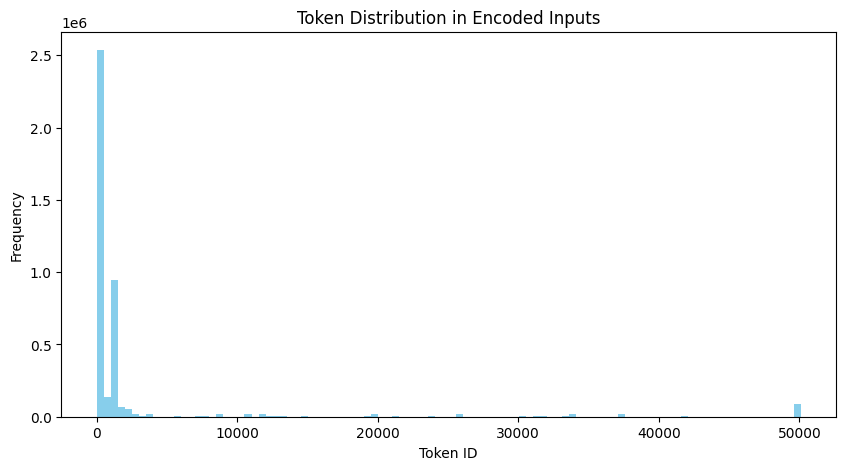

In [22]:
import matplotlib.pyplot as plt
import numpy as np
# Flatten the array of token IDs to get the distribution
flattened_token_ids = np.concatenate([batch['input_ids'].numpy().flatten() for batch in encoded_train])

plt.figure(figsize=(10, 5))
plt.hist(flattened_token_ids, bins=100, color='skyblue')
plt.title('Token Distribution in Encoded Inputs')
plt.xlabel('Token ID')
plt.ylabel('Frequency')
plt.show()

High Frequency of Specific Tokens: The tallest bars at the beginning of the x-axis indicate that there are a few tokens with very high frequency. These are likely to be very common words or symbols, or they could be special tokens like padding tokens.


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50500, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

Getting predictions

In [24]:
def get_predictions(encoded_batches, model):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in encoded_batches:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            probs = softmax(outputs.logits, dim=1)
            batch_predictions = probs.cpu().numpy()
            predictions.extend(batch_predictions)
    return predictions

train_predictions = get_predictions(encoded_train, model)
test_predictions = get_predictions(encoded_test, model)

Evaluation

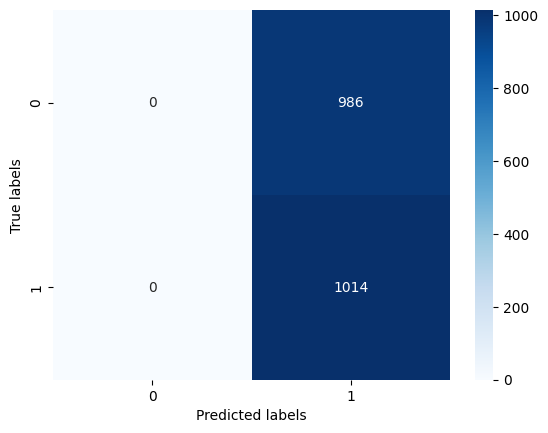

Accuracy: 0.507
Precision: 0.507
Recall: 1.0
F1 Score: 0.6728599867285998


In [25]:
# Convert probabilities to binary predictions
test_preds_binary = np.argmax(test_predictions, axis=1)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, test_preds_binary)
accuracy = accuracy_score(y_test, test_preds_binary)
precision = precision_score(y_test, test_preds_binary)
recall = recall_score(y_test, test_preds_binary)
f1 = f1_score(y_test, test_preds_binary)

# Confusion matrix visualization
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Print performance metrics
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

Getting weird predicitions, most likely an error in the code. Need to figure it out.

### Cleaning body column
Removing URLs, punctuation and special characters in each comment and converting them all to lowercase.

Preprocessing is not needed when using pre-trained language representation models like BERT.
In particular, it uses all of the information in a sentence, even punctuation and stop-words,from a wide range of perspectives by leveraging a multi-head self attention mechanism.
so might not be needed.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)

    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\S*@\S*\s?', '', text)  # Remove emails and mentions
    #text = re.sub(r'[\d]', '', text)  # Remove numbers
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[\.\,\'\"\!\?\:\;\-\_]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

filtered_comments['body'] = filtered_comments['body'].apply(clean_text)
filtered_comments

In [10]:
# Apply the same tokenization process on this smaller dataset
batch_size = 16  # Setting the batch size
encoded_inputs = []

for i in range(0, len(sampled_comments['body']), batch_size):
    batch = sampled_comments['body'][i:i+batch_size].tolist()
    encoded_batch = tokenizer(batch, return_tensors='pt', padding='max_length',
                              max_length=512, truncation=True)
    encoded_inputs.append(encoded_batch)

In [11]:
from torch.nn.functional import softmax
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50500, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [12]:
# List to store the predictions
predictions = []

# Iterate over encoded inputs and make predictions
for batch in encoded_inputs:
    # Move the batch to the same device as the model
    batch = {k: v.to(device) for k, v in batch.items()}

    # Run the model
    with torch.no_grad():
        outputs = model(**batch)

    # Apply softmax to convert logits to probabilities
    probs = softmax(outputs.logits, dim=1)

    # Move the predictions back to the CPU and convert to numpy array
    batch_predictions = probs.cpu().numpy()

    # Store the predictions
    predictions.extend(batch_predictions)

KeyboardInterrupt: 

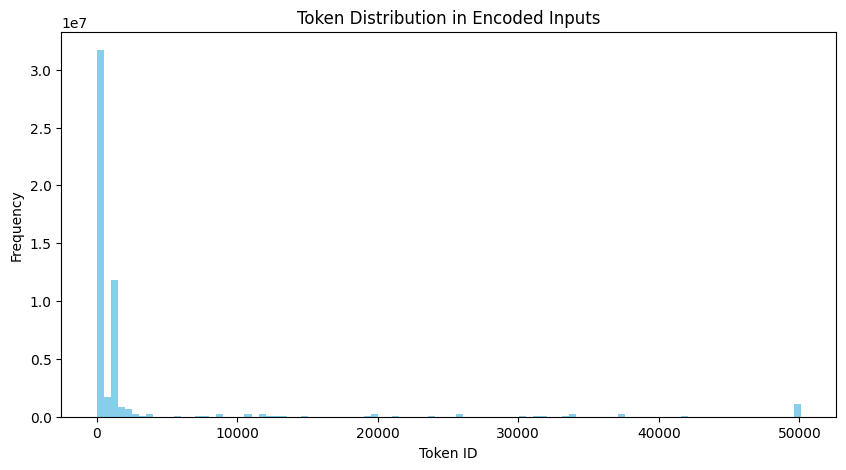

In [ ]:
# Iterate over the dataset in batches
for i in range(0, len(filtered_comments['body']), batch_size):
    # put all body into batches for preprocessing as Bert needs
    batch = filtered_comments['body'][i:i+batch_size].tolist()  # Extract the batch
    #preprocess the text
    encoded_batch = tokenizer(batch, return_tensors='pt', padding='max_length',
                              max_length = 256, truncation=True)
    encoded_inputs.append(encoded_batch)  # Store the tokenized batch